In [1]:
%%capture
!pip install ipywidgets
!pip install autogluon scikit-learn==1.5.2

In [2]:
%%capture
!apt-get install -y graphviz graphviz-dev && pip install pydot
!pip install pygraphviz

In [3]:
import torch
import os
import pydot

import numpy as np
import pandas as pd
from time import time
from tqdm.auto import tqdm
from itertools import combinations

from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
# pd.options.mode.copy_on_write = True
# plt.style.use("ggplot")
# sns.set_style("whitegrid")

## -- Ansi color codes --
COLOR = '\033[32m'
RESET = '\033[0m'

In [4]:
### Load Data ###
PATH = "/kaggle/input/playground-series-s5e10/"
submit = pd.read_csv(PATH+"sample_submission.csv")
train= pd.read_csv(PATH+"train.csv", index_col='id') #.drop('id', axis=1)
test = pd.read_csv(PATH+"test.csv", index_col='id') #.drop('id', axis=1)
orig = pd.read_csv("/kaggle/input/simulated-roads-accident-data/synthetic_road_accidents_100k.csv")

TARGET = "accident_risk"
NUMS = test.select_dtypes(include='number').columns.tolist()
CATS = test.select_dtypes(exclude='number').columns.tolist()
FEATURES = NUMS + CATS

In [5]:
display(train.head())
train.info()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
id,,,,,,,,,,,,,
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


<class 'pandas.core.frame.DataFrame'>
Index: 517754 entries, 0 to 517753
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               517754 non-null  object 
 1   num_lanes               517754 non-null  int64  
 2   curvature               517754 non-null  float64
 3   speed_limit             517754 non-null  int64  
 4   lighting                517754 non-null  object 
 5   weather                 517754 non-null  object 
 6   road_signs_present      517754 non-null  bool   
 7   public_road             517754 non-null  bool   
 8   time_of_day             517754 non-null  object 
 9   holiday                 517754 non-null  bool   
 10  school_season           517754 non-null  bool   
 11  num_reported_accidents  517754 non-null  int64  
 12  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(2), int64(3), object(4)
memory usage: 41.5+ MB


In [6]:
def plot_heatmap(data, cat_features: list, title: str):
    df = data.copy()
    for c in cat_features:
        df[c], _ = pd.factorize(df[c])
    plt.figure(figsize=(18, 7))
    sns.heatmap(df.corr('spearman'), mask=np.triu(df.corr('spearman')), annot=True)
    plt.title(title)
    plt.tight_layout()
    plt.show()

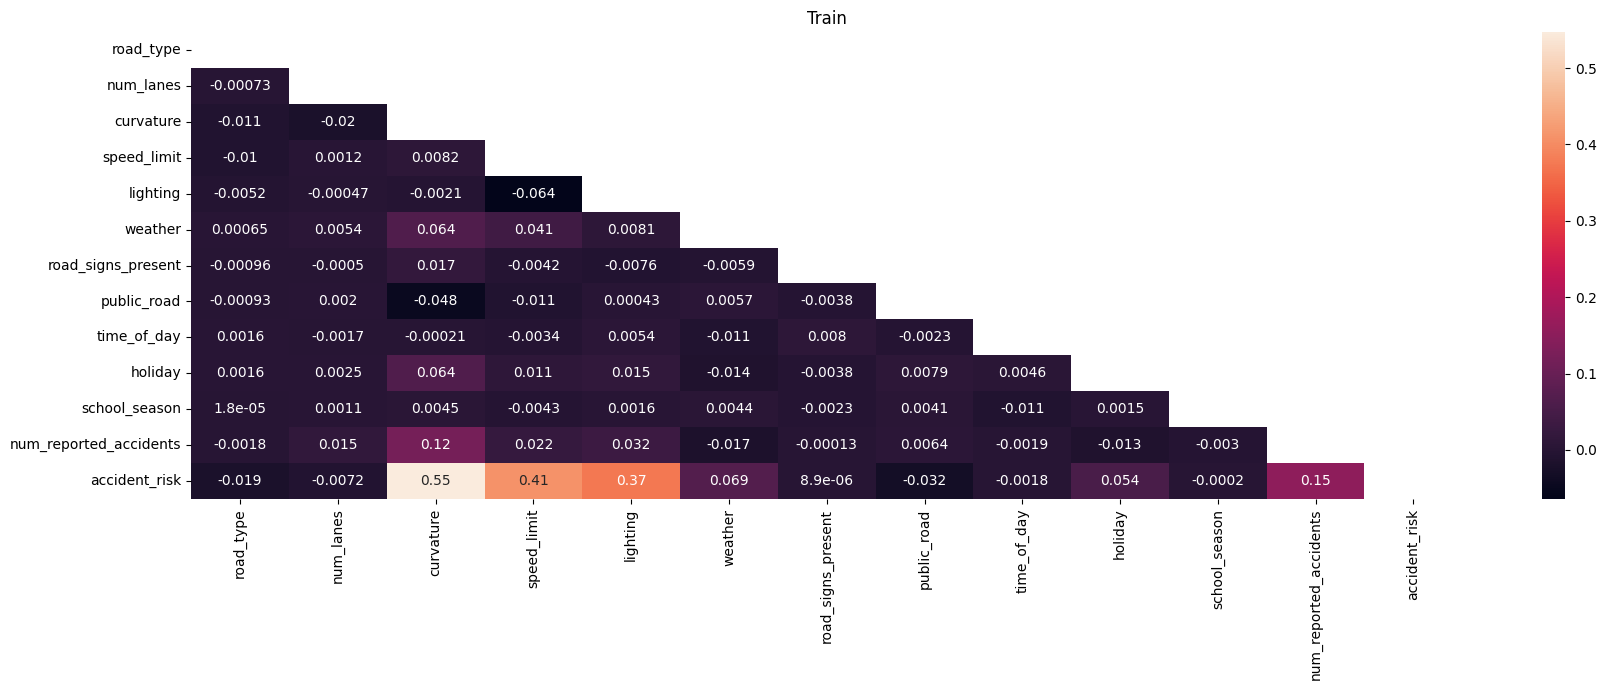

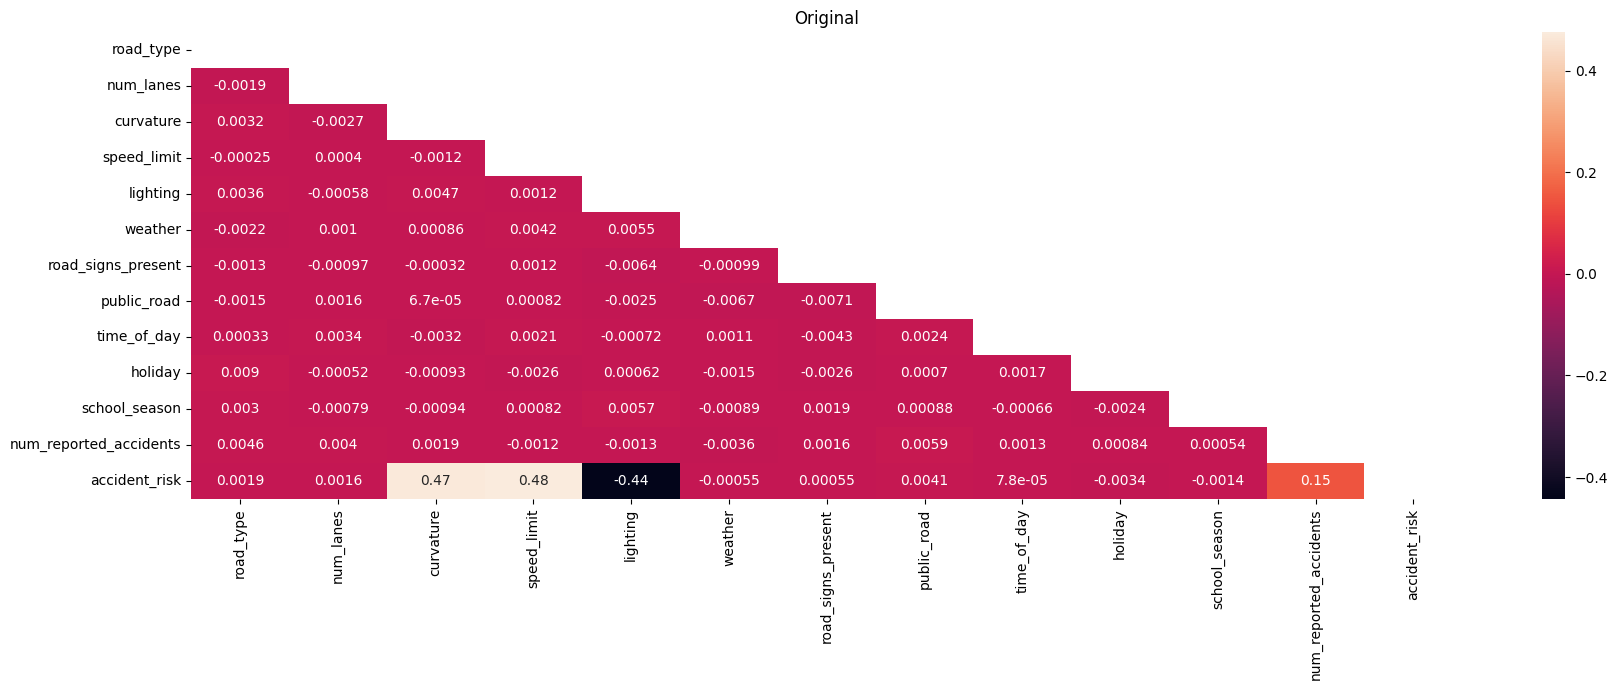

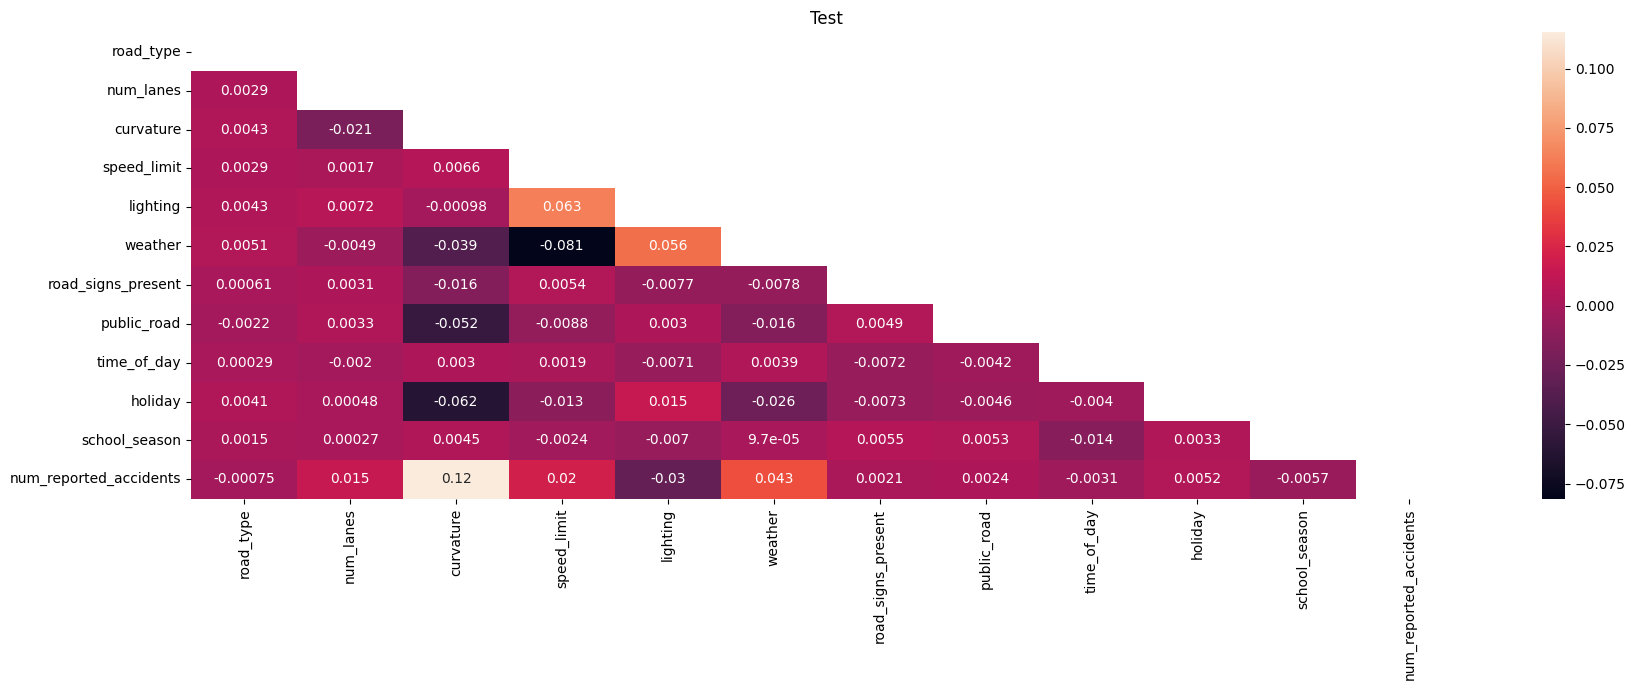

In [7]:
plot_heatmap(train, CATS, "Train")
plot_heatmap(orig, CATS, "Original")
plot_heatmap(test, CATS, "Test")

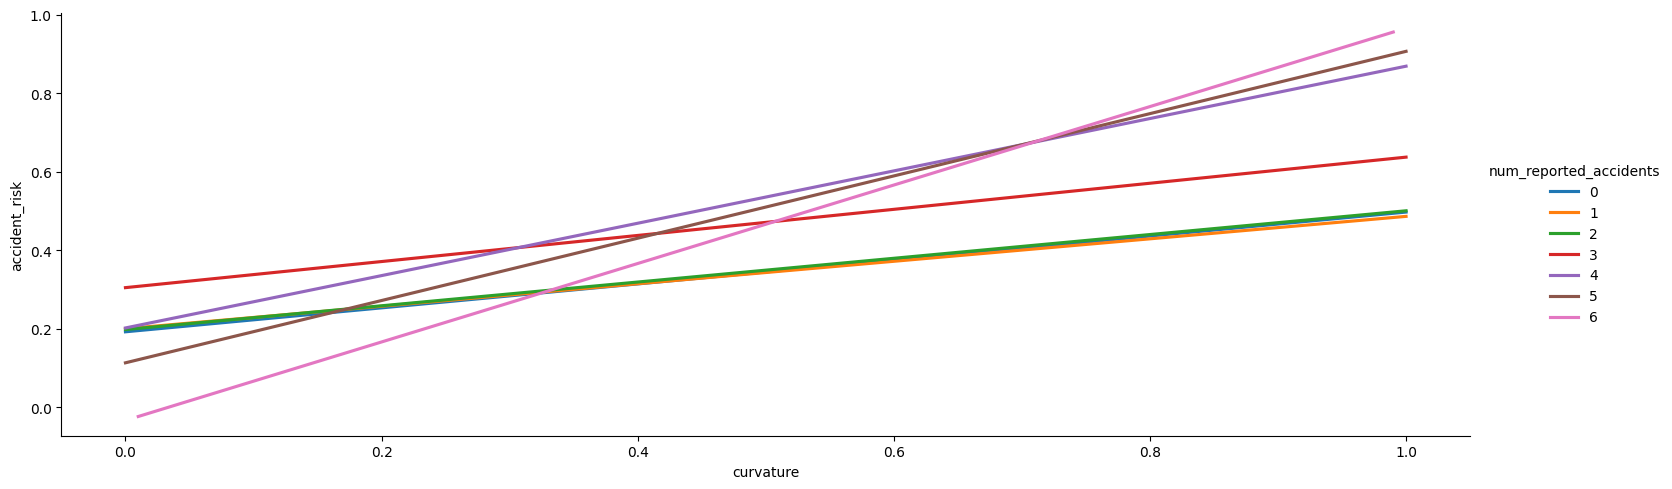

In [8]:
sns.lmplot(train.sample(frac=0.5), x='curvature', y=TARGET, hue='num_reported_accidents',
           seed=0, scatter=False, ci=None, aspect=3.0)
plt.show()

In [9]:
## -- USE ORIGINAL DATA AS COLUMNS --
TOP_PREDICTORS = ['curvature','speed_limit','lighting','weather','num_reported_accidents']
print(f"Merging {len(TOP_PREDICTORS)} features...", end="")

for c in TOP_PREDICTORS:
    tmp = orig.groupby(c)[TARGET].mean()
    n = f"orig_{c}"
    print(f"{n}, ", end="")
    tmp.name = n
    train = train.merge(tmp, on=c, how='left')
    test  = test.merge(tmp, on=c, how='left')
    train.name = 'original_as_columns'

train.shape

Merging 5 features...orig_curvature, orig_speed_limit, orig_lighting, orig_weather, orig_num_reported_accidents, 

(517754, 18)

In [10]:
## -- Feature Engineering --
df = pd.concat([train, test], ignore_index=True)

for col in CATS:
    df[col], _ = pd.factorize(df[col])

df['curvature_bin'] = pd.cut(df['curvature'], bins=np.linspace(0, 1, 5), include_lowest=True, labels=False)
df['curvature_sqrt'] = np.sqrt(df['curvature']) # Square-root
df['curvature_squared'] = df['curvature'] ** 2 # Squared
df['curvature_cubed'] = df['curvature'] ** 3 # Cubed
df['curve+speed+light'] = df[['curvature', 'speed_limit', 'lighting']].sum(axis=1)
print(f"✅ Polynomial features created!!!")

## -- 'meta' feature according to level rules (0.0 to 1.0)
base_risk = (
        0.3 * df["curvature"] +
        0.2 * (df["lighting"] == "night").astype(int) +
        0.1 * (df["weather"] != "clear").astype(int) +
        0.2 * (df["speed_limit"] >= 60).astype(int) +
        0.1 * (np.array(df["num_reported_accidents"]) > 2).astype(int)
    )
df['meta'] = base_risk
print(f"✅ 1 'meta' feature created!!")

train = df.iloc[:len(train)].reset_index(drop=True)
test  = df.iloc[len(train):].drop(TARGET, axis=1).reset_index(drop=True)
print(f"Total features: {len(test)}")

✅ Polynomial features created!!!
✅ 1 'meta' feature created!!
Total features: 172585


In [11]:
# sns.lmplot(train.sample(frac=0.5), x='curvature', y=TARGET, hue='high_risk', 
#            seed=0, ci=None, aspect=3.0)
# plt.show()

In [12]:
display(train.head())
train.info()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,orig_curvature,orig_speed_limit,orig_lighting,orig_weather,orig_num_reported_accidents,curvature_bin,curvature_sqrt,curvature_squared,curvature_cubed,curve+speed+light,meta
0,0,2,0.06,35,0,0,0,0,0,0,0,1,0.13,0.258877,0.302913,0.317187,0.416192,0.362839,0,0.244949,0.0036,0.000216,35.06,0.118
1,0,4,0.99,35,0,1,1,1,1,1,0,0,0.35,0.524931,0.302913,0.317187,0.316435,0.364235,3,0.994987,0.9801,0.970299,35.99,0.397
2,1,4,0.63,70,1,1,0,0,2,1,1,2,0.30,0.430585,0.502361,0.316984,0.316435,0.363362,2,0.793725,0.3969,0.250047,71.63,0.489
3,2,4,0.07,35,1,0,1,0,2,0,1,1,0.21,0.246063,0.302913,0.316984,0.416192,0.362839,0,0.264575,0.0049,0.000343,36.07,0.121
4,1,1,0.58,60,0,2,0,1,1,1,1,1,0.56,0.408129,0.502156,0.317187,0.415742,0.362839,2,0.761577,0.3364,0.195112,60.58,0.474


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   road_type                    517754 non-null  int64  
 1   num_lanes                    517754 non-null  int64  
 2   curvature                    517754 non-null  float64
 3   speed_limit                  517754 non-null  int64  
 4   lighting                     517754 non-null  int64  
 5   weather                      517754 non-null  int64  
 6   road_signs_present           517754 non-null  int64  
 7   public_road                  517754 non-null  int64  
 8   time_of_day                  517754 non-null  int64  
 9   holiday                      517754 non-null  int64  
 10  school_season                517754 non-null  int64  
 11  num_reported_accidents       517754 non-null  int64  
 12  accident_risk                517754 non-null  float64
 13 

In [13]:
display(test.head())
test.info()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,orig_curvature,orig_speed_limit,orig_lighting,orig_weather,orig_num_reported_accidents,curvature_bin,curvature_sqrt,curvature_squared,curvature_cubed,curve+speed+light,meta
0,2,2,0.34,45,2,1,1,0,0,1,0,1,0.342864,0.302666,0.514154,0.316435,0.362839,1,0.583095,0.1156,0.039304,47.34,0.202
1,0,3,0.04,45,1,2,1,1,0,1,1,0,0.246377,0.302666,0.316984,0.415742,0.364235,0,0.200000,0.0016,0.000064,46.04,0.112
2,0,2,0.59,35,1,1,1,1,0,1,0,1,0.413919,0.302913,0.316984,0.316435,0.362839,2,0.768115,0.3481,0.205379,36.59,0.277
3,1,4,0.95,35,0,0,0,1,0,0,1,2,0.519313,0.302913,0.317187,0.416192,0.363362,3,0.974679,0.9025,0.857375,35.95,0.385
4,2,2,0.86,35,0,1,1,1,1,0,0,3,0.478877,0.302913,0.317187,0.316435,0.464335,3,0.927362,0.7396,0.636056,35.86,0.458


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172585 entries, 0 to 172584
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   road_type                    172585 non-null  int64  
 1   num_lanes                    172585 non-null  int64  
 2   curvature                    172585 non-null  float64
 3   speed_limit                  172585 non-null  int64  
 4   lighting                     172585 non-null  int64  
 5   weather                      172585 non-null  int64  
 6   road_signs_present           172585 non-null  int64  
 7   public_road                  172585 non-null  int64  
 8   time_of_day                  172585 non-null  int64  
 9   holiday                      172585 non-null  int64  
 10  school_season                172585 non-null  int64  
 11  num_reported_accidents       172585 non-null  int64  
 12  orig_curvature               172460 non-null  float64
 13 

In [14]:
# !rm -r /kaggle/working/AG_accident_models

In [15]:
from autogluon.tabular import TabularPredictor

## -- RUN 1: Use train data --
predictor = TabularPredictor(
                label = TARGET,
         problem_type = "regression",
          eval_metric = "rmse",
                 path = "./AG_accident_models",
).fit(
                   train_data = train,
                      presets = 'medium',
                num_bag_folds = 10,
             dynamic_stacking = False,
             num_stack_levels = 1,
                 # num_bag_sets = 2,
                   time_limit = 3600*11.5,
        # [ 'XGB', 'GBM', 'CAT', 'RF', 'XT', 'FASTAI', 'NN_TORCH']
         # included_model_types = ['RF', 'XT', 'FASTAI'],
                     # num_gpus = torch.cuda.device_count(),
                  # ag_args_fit = {'num_cpus': os.cpu_count() - 1},
)

Preset alias specified: 'medium' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       29.64 GB / 31.35 GB (94.5%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['medium']
Using hyperparameters preset: hyperparameters='default'
Beginning AutoGluon training ... Time limit = 41400s
AutoGluon will save models to "/kaggle/working/AG_accident_models"
Train Data Rows:    517754
Train Data Columns: 23
Label Column:       accident_risk
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    30323.86 MB
	Train Data (Original)  Memory Usage: 90.85 MB (0.3% of available memory

In [16]:
## -- Get Summary -- 
print(f"""
    ---> Total models : {len(predictor.model_names())}
    ---> Best model   : {predictor.model_best}
        """)

## -- Observe RUN 1 RESULTS --
leaderboard = predictor.leaderboard(silent=True)
display(leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral"))


    ---> Total models : 20
    ---> Best model   : WeightedEnsemble_L3
        


,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.055843,root_mean_squared_error,306.811683,8650.030687,0.011868,1.520126,3,True,20
1,ExtraTreesMSE_BAG_L2,-0.055874,root_mean_squared_error,263.356493,6371.546309,27.654660,478.418370,2,True,15
2,LightGBM_BAG_L2,-0.055954,root_mean_squared_error,244.576381,6016.768239,8.874548,123.640301,2,True,12
3,LightGBMLarge_BAG_L2,-0.055958,root_mean_squared_error,253.663442,6071.937111,17.961609,178.809173,2,True,19
4,WeightedEnsemble_L2,-0.055964,root_mean_squared_error,91.982504,1890.773978,0.011616,0.820061,2,True,10
5,XGBoost_BAG_L2,-0.055970,root_mean_squared_error,240.106606,5977.083030,4.404773,83.955092,2,True,17
6,CatBoost_BAG_L2,-0.055979,root_mean_squared_error,236.847059,6800.714655,1.145226,907.586717,2,True,14
7,NeuralNetFastAI_BAG_L2,-0.055980,root_mean_squared_error,243.247372,7331.124087,7.545539,1437.996149,2,True,16
8,LightGBMLarge_BAG_L1,-0.055989,root_mean_squared_error,19.706771,166.611098,19.706771,166.611098,1,True,9
9,CatBoost_BAG_L1,-0.056022,root_mean_squared_error,1.238842,1103.268820,1.238842,1103.268820,1,True,4


In [17]:
## -- RUN 2: Use original data as extra learning input --
# predictor.fit_pseudolabel(
#                 orig,
#                 use_ensemble = True,
#                 fit_ensemble = True,
#                 time_limit   = 3600*5,
#                 ag_args_fit  = {'num_cpus': os.cpu_count() - 1},
# )

In [18]:
## -- Get Summary -- 
# print(f"""
#     # {'█'*5}| Total models : {len(predictor.model_names())}
#     # {'█'*5}| Best model   : {predictor.model_best}
#         """)

# # -- Observe RUN 2 RESULTS --
# leaderboard = predictor.leaderboard(silent=True)
# display(leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral"))

In [19]:
## -- Create folder directory to save predictions --
NAME_EXT = "_FE-22-CPU"
FOLDER   = "AG_accident_predictions"
!mkdir /kaggle/working/{FOLDER}{NAME_EXT}

In [20]:
## -- Make predictions from best model --
pred_df = predictor.predict(test)

## -- Make Submission --
submit = pd.read_csv(PATH+"sample_submission.csv")

SUBMIT_FILE = f'submit_AG{NAME_EXT}.csv'
submit[TARGET] = pred_df.values
submit.to_csv(SUBMIT_FILE, index=False)
print(f"---> Submission file saved as: {SUBMIT_FILE} !")
submit.head(10)

---> Submission file saved as: submit_AG_FE-22-CPU.csv !


,id,accident_risk
0,517754,0.300775
1,517755,0.121700
2,517756,0.183940
3,517757,0.312541
4,517758,0.405676
5,517759,0.454946
6,517760,0.261234
7,517761,0.196702
8,517762,0.369572
9,517763,0.325048


In [21]:
## -- Generate prediction probabilities for all models --
ag_multi_test_proba = predictor.predict_multi(test)

## -- Get TEST PREDICTIONS of all models --
final_test_data = {}
DESC = "Exporting TEST predictions"

for k, v in tqdm(ag_multi_test_proba.items(), desc=DESC):
    k_renamed = k.replace('_', '') + NAME_EXT
    final_test_data[k_renamed] = v

SAVE_PRED = f"/kaggle/working/{FOLDER}{NAME_EXT}/pred_ag{NAME_EXT}.parquet"
final_test_df = pd.DataFrame(final_test_data)
final_test_df.to_parquet(SAVE_PRED, index=False)
final_test_df.head()

Exporting TEST predictions:   0%|          | 0/20 [00:00<?, ?it/s]

,LightGBMXTBAGL1_FE-22-CPU,LightGBMBAGL1_FE-22-CPU,RandomForestMSEBAGL1_FE-22-CPU,CatBoostBAGL1_FE-22-CPU,ExtraTreesMSEBAGL1_FE-22-CPU,NeuralNetFastAIBAGL1_FE-22-CPU,XGBoostBAGL1_FE-22-CPU,NeuralNetTorchBAGL1_FE-22-CPU,LightGBMLargeBAGL1_FE-22-CPU,WeightedEnsembleL2_FE-22-CPU,LightGBMXTBAGL2_FE-22-CPU,LightGBMBAGL2_FE-22-CPU,RandomForestMSEBAGL2_FE-22-CPU,CatBoostBAGL2_FE-22-CPU,ExtraTreesMSEBAGL2_FE-22-CPU,NeuralNetFastAIBAGL2_FE-22-CPU,XGBoostBAGL2_FE-22-CPU,NeuralNetTorchBAGL2_FE-22-CPU,LightGBMLargeBAGL2_FE-22-CPU,WeightedEnsembleL3_FE-22-CPU
0,0.291382,0.292449,0.316737,0.292349,0.312417,0.298774,0.292416,0.303333,0.292599,0.294701,0.300568,0.294854,0.303304,0.295602,0.303980,0.293484,0.295062,0.309645,0.295421,0.300775
1,0.120336,0.124246,0.122379,0.120547,0.119272,0.119390,0.121211,0.128812,0.125748,0.123128,0.119212,0.123361,0.115211,0.121539,0.122247,0.123882,0.122855,0.134445,0.123349,0.121700
2,0.190695,0.190228,0.172994,0.186852,0.175817,0.190668,0.184814,0.195646,0.182147,0.183910,0.182728,0.182816,0.186906,0.182919,0.183423,0.182004,0.183220,0.190601,0.182743,0.183940
3,0.314778,0.315635,0.320945,0.308866,0.316547,0.310147,0.314828,0.329974,0.321124,0.315919,0.315136,0.316734,0.308433,0.314429,0.311358,0.315169,0.316356,0.322537,0.316110,0.312541
4,0.398008,0.393859,0.408576,0.394218,0.408946,0.396049,0.399021,0.391654,0.407343,0.401648,0.398976,0.398135,0.403143,0.399674,0.408267,0.401049,0.397517,0.389275,0.400220,0.405676


In [22]:
## -- Get OOF predictions of all models --
ag_multi_oof_preds = {}
DESC1 = "Processing OOF probabilities"

for model in tqdm(predictor.model_names(), desc=DESC1):
    ag_multi_oof_preds[model] = predictor.predict_oof(
                                     model = model,
                                train_data = train
                            )

final_oof_data = {}
DESC2 = "Exporting OOF predictions"

for k, v in tqdm(ag_multi_oof_preds.items(), desc=DESC2):
    k_renamed = k.replace('_', '') + NAME_EXT
    final_oof_data[k_renamed] = v
    
SAVE_OOF = f"/kaggle/working/{FOLDER}{NAME_EXT}/oof_ag{NAME_EXT}.parquet"
final_oof_df = pd.DataFrame(final_oof_data)
final_oof_df.to_parquet(SAVE_OOF, index=False)
final_oof_df.head()

Processing OOF probabilities:   0%|          | 0/20 [00:00<?, ?it/s]

Exporting OOF predictions:   0%|          | 0/20 [00:00<?, ?it/s]

,LightGBMXTBAGL1_FE-22-CPU,LightGBMBAGL1_FE-22-CPU,RandomForestMSEBAGL1_FE-22-CPU,CatBoostBAGL1_FE-22-CPU,ExtraTreesMSEBAGL1_FE-22-CPU,NeuralNetFastAIBAGL1_FE-22-CPU,XGBoostBAGL1_FE-22-CPU,NeuralNetTorchBAGL1_FE-22-CPU,LightGBMLargeBAGL1_FE-22-CPU,WeightedEnsembleL2_FE-22-CPU,LightGBMXTBAGL2_FE-22-CPU,LightGBMBAGL2_FE-22-CPU,RandomForestMSEBAGL2_FE-22-CPU,CatBoostBAGL2_FE-22-CPU,ExtraTreesMSEBAGL2_FE-22-CPU,NeuralNetFastAIBAGL2_FE-22-CPU,XGBoostBAGL2_FE-22-CPU,NeuralNetTorchBAGL2_FE-22-CPU,LightGBMLargeBAGL2_FE-22-CPU,WeightedEnsembleL3_FE-22-CPU
0,0.129306,0.129283,0.130569,0.127291,0.128394,0.130522,0.131466,0.130525,0.129038,0.128411,0.129060,0.129800,0.129425,0.128731,0.128645,0.126727,0.130835,0.135578,0.129924,0.128798
1,0.319002,0.322260,0.323542,0.326107,0.318218,0.319910,0.326627,0.323138,0.323416,0.323607,0.323194,0.324657,0.319992,0.320081,0.319772,0.322324,0.324840,0.329875,0.323159,0.321126
2,0.393637,0.389015,0.389024,0.389661,0.387378,0.393612,0.388382,0.388315,0.389867,0.389427,0.389272,0.387665,0.381441,0.389969,0.382525,0.390886,0.388532,0.386618,0.387382,0.384296
3,0.126701,0.129038,0.136165,0.130180,0.131088,0.131270,0.128920,0.146572,0.129939,0.130047,0.130028,0.130787,0.133994,0.133847,0.131769,0.129289,0.130272,0.135980,0.130875,0.131642
4,0.469429,0.468184,0.472768,0.469001,0.469141,0.471350,0.468164,0.468322,0.468557,0.468728,0.468475,0.468717,0.459109,0.468794,0.465386,0.468974,0.468415,0.469667,0.469279,0.465438


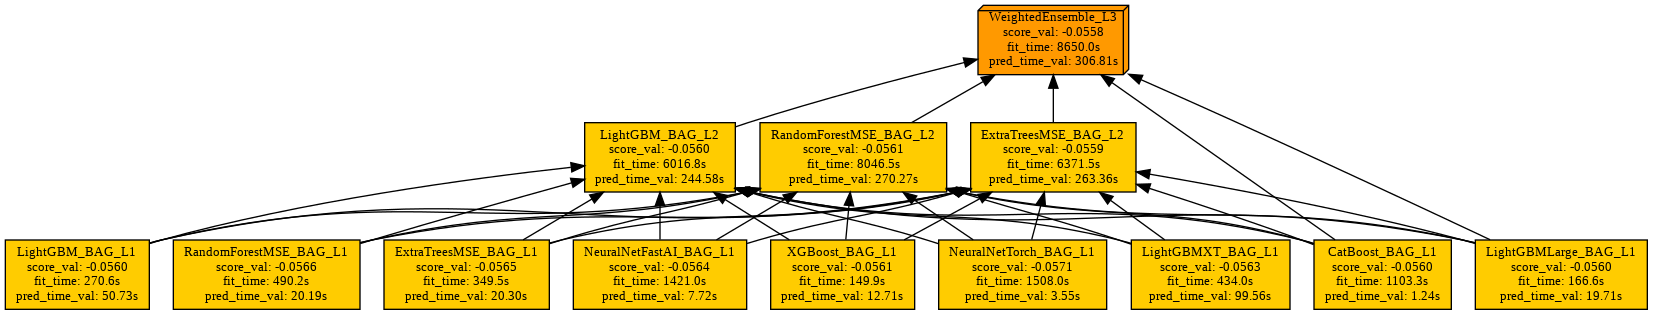

In [23]:
predictor.plot_ensemble_model(filename='ensemble_model.png')
display(Image('./AG_accident_models/ensemble_model.png'))

In [24]:
# !zip -r /kaggle/working/AG_accident_models /kaggle/working/AG_accident_models.zip
!zip -r {FOLDER}{NAME_EXT}.zip /kaggle/working/{FOLDER}{NAME_EXT}

  adding: kaggle/working/AG_accident_predictions_FE-22-CPU/ (stored 0%)
  adding: kaggle/working/AG_accident_predictions_FE-22-CPU/oof_ag_FE-22-CPU.parquet (deflated 10%)
  adding: kaggle/working/AG_accident_predictions_FE-22-CPU/pred_ag_FE-22-CPU.parquet (deflated 9%)


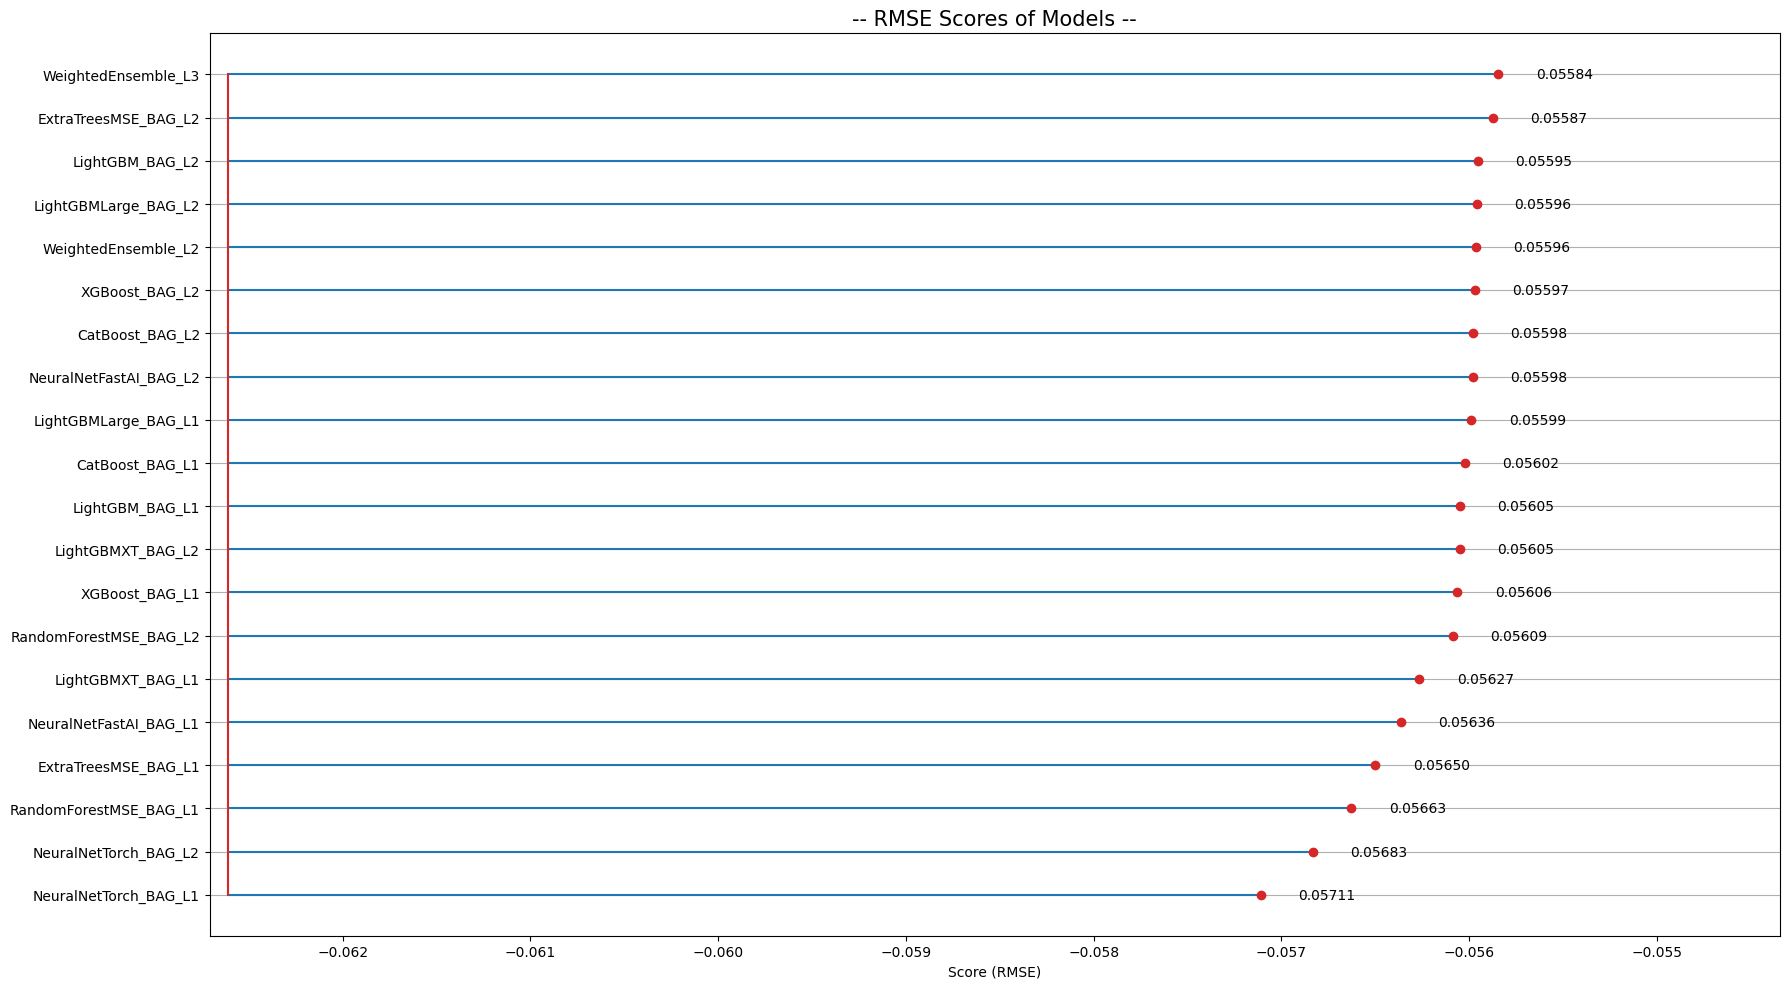

In [25]:
## -- EXTRACT MODEL AND SCORES --
result_dict = dict(zip(leaderboard['model'], leaderboard['score_val']))
result_df = pd.DataFrame.from_dict(result_dict, orient='index').sort_values(0)

max_score = result_df.max().item()
min_score = result_df.min().item()

## -- PLOT MODELS & SCORES --
plt.figure(figsize=(18, 10))
plt.stem(
    result_df.index,
    result_df[0],
    orientation = 'horizontal',
    bottom = min_score - 0.0055,
    markerfmt = 'C3o'
)
plt.xlim(min_score - 0.0056, max_score + 0.0015)
plt.xlabel('Score (RMSE)')
plt.title('-- RMSE Scores of Models --', fontsize=15)

for i, value in enumerate(result_df[0]):
    plt.text(value+2e-4, i, f'{abs(value):.5f}', ha='left', va='center')

plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [26]:
## -- OPTIONAL: Remove stored files --
!rm -r /kaggle/working/AG_accident_models
!rm -r /kaggle/working/{FOLDER}{NAME_EXT}

In [27]:
print(f"""
{'-'*48}
{'█'*5} | - AUTOGLUON NOTEBOOK COMPLETE! - | {'█'*5}
{'-'*48}
""")


------------------------------------------------
█████ | - AUTOGLUON NOTEBOOK COMPLETE! - | █████
------------------------------------------------

